# MINST

A set of 70,000 hand written images of digits.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

The `data` key contains an array with one row per instance and one column per feature. The `target` key cointains the array with the labels:

In [4]:
X, y = mnist["data"], mnist["target"]

## data

`data` has 70,000 images, each image has 784 features. A feature is a pixel on a 28 x 28 grid, ranging from 0 (white) to 255 (black)

In [9]:
X.shape

(70000, 784)

Let's take a peek at `data`:

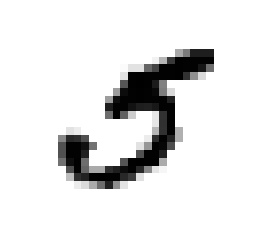

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

It looks half-5 and half-6. Let's see what the label tells us

In [12]:
y[36000]

5.0

Create a training set (60k images) and a training set (10k images):

In [13]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

Let's suffle the training set, as this will guarantee that all cross-validation folds will be similar. You don't want some set to be missing certain digits. Some algorithms are also senstive to the order of training cases.

In [14]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

# Training a Binary Classifier

Let's simplify the problem and build a *binrary-classifier*, one that identifies a digit as 5 and not-5.

In [15]:
y_train_5 = (y_train == 5)
y_test_5  = (y_test == 5)

> `SGDClassifier` relies on randomness during training. If you want reproducible result, set the `random_state` parameter

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. Here are some techniques.

### Using Cross Validation

> For user-defined cross-validation, see the book

Let's use `cross_val_score()` to evaluate `SGDClassifier` using K-fold validation with `K = 3`. Recall that K-fold validation means splitting a set into K-folds, making predictions and evaluating them on each fold using a model trained on the remaining folds. (see chapter 2)

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([ 0.95385,  0.89035,  0.9628 ])

The result seems too good: almost 90%-accuracy for every case, but there's more than meets the eyes. Let's a dumb classifier that classifies every single image as "not-5":

In [26]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9069 ,  0.9097 ,  0.91235])

It got 90% accuracy too: because only about 10% of the images are 5, a blind guess would have been correct 90% of the time.

> This is why acuracy is generally not a preferred performance measure for classifiers, espcially when you are dealing with skewed datasets, where some classes are much more frequent than others.

### Confusion Matrix

A much better way to evaluate classifiers. We want to count the number of times class A is misclassified as class B. For example, to find the number of times that images of 5s are confused with images of 3, looking at the 5th row and 3rd column.

To compute the confusion matrix, you first need to have a set of predictions so they can be compared to the label. You can make predictions on the entire test set, but you should not: you want to use the test set only at the very end, when you are ready to launch your model. 

Use `cross_val_predict()` instead. It uses K-fold validation to return predict on each test fold. This means you get clean prediction for each instance in the training set ("clean" meaning that the predict is made by a model that never saw the data during training).

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([[51902,  2677],
       [ 1183,  4238]], dtype=int64)

Each row represents the *actual class*. Each column represent the *predicted class*. The first row contains images that are not-5. The first column contains images that are predicted to be not-5. Clockwise from top-left: true-negative, false-negative, false-positive and true-positive. A perfect classifier would return 0 on the false-negative and false-postive:

```
confusion_matrix(y_train_5, y_train_pred)
array([[54579,    0],
       [0    , 5421]])
```

You can combine cells in this matrix to calculate the precision & recall:

$$
\begin{align}
\text{precision} &= \frac{\text{true positive}}{\text{true positive}+\text{false negative}}
\\[10pt]
\text{recall} &= \frac{\text{true positive}}{\text{true positive}+\text{false negative}}
\end{align}
$$

### Precision and Recall

In [30]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.61287057122198119

In [31]:
recall_score(y_train_5, y_train_pred)

0.78177458033573144

Now it doesn't look so hot! It's correct only 61% of the time and can only detect 78% of the 5s. It's convenient to combine the 2 metrics together into 1: the $F_1$ score:

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
    = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.68709468223086889

The $F_1$ score favors classifier that have similar precision and recall. This is not desirable in all cases. For example:

* If you are developing a classifier to detect if a video is safe for kids, you would propapbly prefer one that rejects many good video (low recall) and keep only safe ones (high precision).
* If you are training a classifier to detect shoplifting, you would prefer high recall and low precision. That means security has to work harder but almost all shoplifters are caught.

Unfortunately you can't have both, as increasing one decreases the other: the *precision/recall tradeoff*.

### The Precision / Recall tradeoff

`SGDClassifier` makes its classification decision based on a decision function. If the score is above a threshold, it assigns the instance to the positive class. You can't access the threshold directly but you can see what score it gives to each instance

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-61837.3161928])

`SGDClassifier` uses a default threshold of 0. Increasing the threshold give increases decision and decrease recall and vice-versa. So how can you decide which one to use?

For this you will first need to get the scores of all instances in the training set using `cross_val_predict()`:

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Now you can compute precision and recall for all possible threshold using `precision_recall_curve()`:

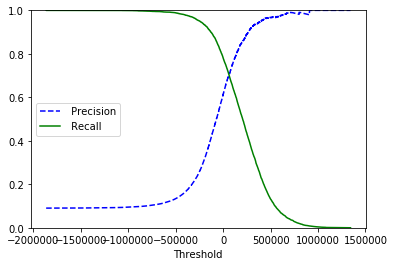

In [42]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold( precisions, recalls, thresholds):
    plt.plot( thresholds, precisions[:-1], "b--", label =" Precision")
    plt.plot( thresholds, recalls[:-1], "g-", label =" Recall")
    plt.xlabel("Threshold")
    plt.legend( loc ="center left")
    plt.ylim([ 0, 1]) 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold( precisions, recalls, thresholds)
plt.show()

Another way to look at it is the precision-vs-recall curve:

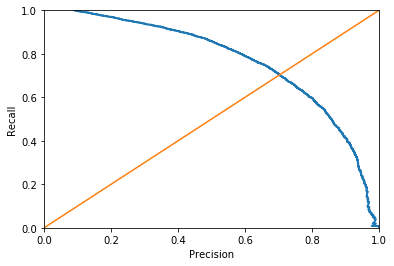

In [75]:
def plot_pr_curve(precisions, recalls):
    plt.plot(precisions, recalls, linewidth=2)
    plt.plot([0,1], [0,1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    
plot_pr_curve(precisions, recalls)
plt.show()

So let's say you want to keep precision at 90% and the charts tell you that a threshold of 300,000 will do that:

In [65]:
y_train_pred_90 = (y_scores > 300_000)

In [66]:
precision_score(y_train_5, y_train_pred_90), 

(0.92216981132075471,)

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.3606345692676628

In [68]:
f1_score(y_train_5, y_train_pred_90)

0.51849887282853735

Now you have a 92%-precision classifier. Next time anyone ask for a 99% precision classifier, you should ask "at what recall"?

### The ROC Curve

The reciver operating characteristic (ROC) curve is another common tool used with **binary classifiers**. It is very similar to the precision / recal curve. It posts the *true positive rate* (another name for recall) against the *false positive rate*.

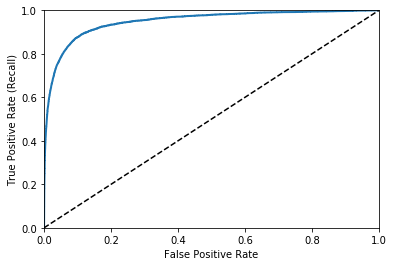

In [71]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

Again, there's a trade off: the higher the true positive rate, the higher the false positive rate. The dotted line represents a purely random classifier. A good classifier should stay as far away from it as possible (toward the top-left corner).

One way to compare classifier to measure the area under the curve (AUC). A perfect classifier has AUC = 1. A purely random classifier has AUC = 0.5

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.94905377551165515

> Since the ROC curve is so similar to the precision/ recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

### ROC Curve: a comparison

In [78]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

To plot the ROC curve, you need scores, not probabilities. A simple solution is to use the positive class probability as the score:

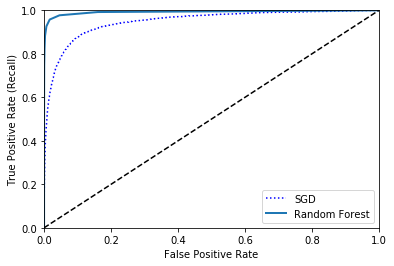

In [82]:
y_scores_forest = y_probas_forest[:, 1] # scores = probas of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

The ROC curve of Random Forest looks much better and consequently, its AUC is higher too:

In [84]:
roc_auc_score(y_train_5, y_scores_forest)

0.99251268853716934

## Multiclass Classification

* Binary classifier distinguhes between 2 claseses.
* Multiclass classifier handle multiple classes simultaneously.
* One versus all / one versus the rest: one classifier for each digit. Then pick the highest precision score.
* One versus one: test every pair of digits against each other (45 test total) and see who wins the most duels. Some classifiers, like Support Vector Machine, scales poorly with the size of the training set. For them, more advantages to train many classifiers on small training set and train few classifiers on larger set.

For most cases, OvA is a better strategy. Scikit-Learn detects when you use a binary classifiers for a multiclassification problem and use OvA automatically.

In [86]:
sgd_clf.fit(X_train, y_train) # y_train not y_train_5
sgd_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

It actually trains 10 binary classifiers in the background

In [89]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-260658.89718872, -391148.03170142, -267044.73218133,
         -66475.58489122, -559614.9562955 ,  -61837.3161928 ,
        -759071.68619693, -354486.64885349, -651060.72457531,
        -652653.02494488]])

Scikit-Learn picks the class with the highest decision function:

In [90]:
np.argmax(some_digit_scores)

5

In [92]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

### Forcing a One vs One Strategy

Use the `OneVsOneClassifier` or `OneVsRestClassifier`, passing a binary classifier to its constructor:

In [94]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
          n_jobs=1)

In [96]:
ovo_clf.predict([some_digit])

array([ 5.])

In [97]:
len(ovo_clf.estimators_)

45

Train with Random Forest Classifier:

In [98]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

SKL didn't have to choose a OvA or OvO strategy since `RandomForestClassifier` is a multiclassifier. Get the propability that the instance belongs to each class with `predict_proba`:

In [101]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

The classifier is very confident that the number is a 5.

### Evalutaing their performance

Evaluate the accuracy of the classifier on the whole training set:

In [103]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([ 0.86612677,  0.85344267,  0.86693004])

You can improve it further with *scaling* (see chapter 2):